In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-3.1/transformers/8b-instruct/2/model.safetensors.index.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00003-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/LICENSE
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00001-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/README.md
/kaggle/input/llama-3.1/transformers/8b-instruct/2/USE_POLICY.md
/kaggle/input/llama-3.1/transformers/8b-instruct/2/tokenizer.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/tokenizer_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00004-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/special_tokens_map.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/.gitattributes
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00002-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/gener

In [2]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [3]:
!pip install wandb
#!wandb login

In [4]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune llama-3.1-8b-it on Newspaper Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cse-mahmud-evan (cse-mahmud-evan-ccn-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241001_202301-p67ynr8x
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dashing-deluge-3
wandb: ⭐️ View project at https://wandb.ai/cse-mahmud-evan-ccn-university-of-science-and-technology/Fine-tune%20llama-3.1-8b-it%20on%20Newspaper%20Datas

In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging
)
from sklearn.metrics import (

    accuracy_score,
    classification_report,
    confusion_matrix   
)
from sklearn.model_selection import train_test_split

In [6]:
import numpy as np
import pandas as pd

data = pd.read_json('/kaggle/input/bangla-newspaper-dataset/data_v2/data_v2.json')
data.head()

,author,category,category_bn,published_date,modification_date,tag,comment_count,title,url,content
0,গাজীপুর প্রতিনিধি,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২৩:২৬","০৪ জুলাই ২০১৩, ২৩:২৭",[গাজীপুর],0,"কালিয়াকৈরে টিফিন খেয়ে ৫০০ শ্রমিক অসুস্থ, বিক...",http://www.prothom-alo.com/bangladesh/article/...,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...
1,অনলাইন ডেস্ক,sports,খেলা,"০৪ জুলাই ২০১৩, ২৩:০৯","০৪ জুলাই ২০১৩, ২৩:১১",[টেনিস],0,সেমিফাইনাল বাধাও পেরিয়ে গেলেন লিসিকি,http://www.prothom-alo.com/sports/article/19028,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...
2,নিজস্ব প্রতিবেদক,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২২:২৫","০৪ জুলাই ২০১৩, ২৩:১২",[রাজনীতি],0,সংসদে খালেদার অভিযোগের জবাব দিয়েছে ভারত,http://www.prothom-alo.com/bangladesh/article/...,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...
3,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৭","০৪ জুলাই ২০১৩, ২১:৪৫",[গবেষণা],0,পাসওয়ার্ড ভুলে যান!,http://www.prothom-alo.com/technology/article/...,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...
4,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৫","০৪ জুলাই ২০১৩, ২১:৩৭",[কম্পিউটার],0,চলে গেলেন মাউস উদ্ভাবক,http://www.prothom-alo.com/technology/article/...,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...


In [7]:
len(data.columns)

10

In [8]:
ndf = data[['content','category']]

In [9]:
ndf.shape

(408471, 2)

In [10]:
ndf.duplicated().sum()

1567

In [11]:
ndf.drop_duplicates(inplace= True)

/tmp/ipykernel_24/3272145479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.drop_duplicates(inplace= True)


In [12]:
ndf.shape

(406904, 2)

In [13]:
ndf.category.unique()

array(['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education'],
      dtype=object)

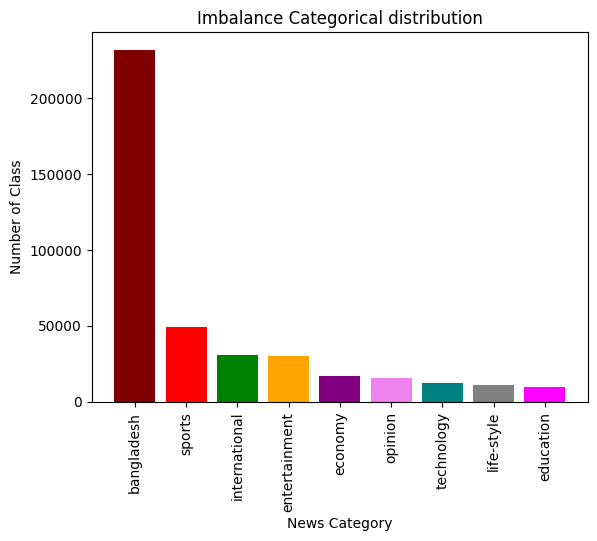

In [14]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt


color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

labels = ndf['category'].value_counts().index
values = ndf['category'].value_counts().values

plt.bar(labels,values, color = color_palette)
plt.title("Imbalance Categorical distribution")
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of Class')



plt.show()

In [15]:
'''from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
ndf['category'] = lbl.fit_transform(ndf['category'])'''

"from sklearn.preprocessing import LabelEncoder\nlbl = LabelEncoder()\nndf['category'] = lbl.fit_transform(ndf['category'])"

In [16]:
ndf.head()

,content,category
0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,bangladesh
1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,sports
2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,bangladesh
3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,technology
4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,technology


In [17]:
!pip install imblearn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [18]:

from imblearn.under_sampling import RandomUnderSampler

A = ndf.drop('category',axis = 1)
b = ndf['category']

rus = RandomUnderSampler()

A_resampled, b_resampled = rus.fit_resample(A,b)

resampled_df = pd.DataFrame(A_resampled,columns = A.columns)
resampled_df['category'] = b_resampled

resampled_df = resampled_df.sample(frac = 1, random_state = 85).reset_index (drop=True)

In [19]:
resampled_df.head()

,content,category
0,গ্যালাক্সি এস৯ নিয়ে আলোচনা ফুরাতে না ফুরাতেই এ...,technology
1,পুঁজিবাজারে তালিকাভুক্ত বিমা খাতের কোম্পানি নর...,economy
2,ক্যানসার প্রথম দিকে ধরা পড়লে বেঁচে থাকার সম্ভা...,life-style
3,সরকারি ও স্বায়ত্তশাসিত প্রতিষ্ঠানগুলো জনবল নি...,opinion
4,"অধ্যায়-৩ প্রিয় শিক্ষার্থী, আজ প্রাথমিক বিজ্ঞা...",education


In [20]:
resampled_df.shape

(86868, 2)

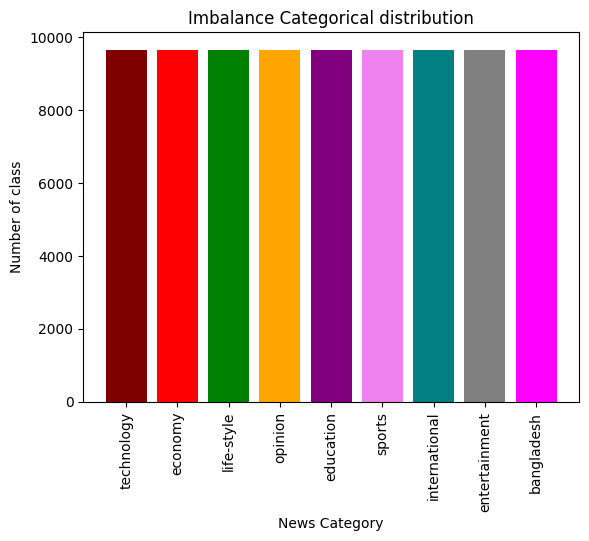

In [21]:
#category distribution
labels = resampled_df['category'].value_counts().index
values = resampled_df['category'].value_counts().values

color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

#plot bar chart
plt.bar(labels,values, color = color_palette)
plt.title('Imbalance Categorical distribution')
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of class')
plt.show()

In [22]:
resampled_df['category'].value_counts()

category
technology       9652
economy          9652
life-style       9652
opinion          9652
education        9652
sports           9652
international    9652
entertainment    9652
bangladesh       9652
Name: count, dtype: int64

In [23]:
ndf = resampled_df.sample(frac= 1, random_state = 48).reset_index(drop=True).head(1000)
ndf.head()

,content,category
0,পাকিস্তানের প্রধানমন্ত্রী নওয়াজ শরিফের পদত্যা...,international
1,নিল লেনন তো ভীষণ খ্যাপা। এ রকম ফাউল নাকি হতেই ...,sports
2,প্রতিদ্বন্দ্বী অ্যাপল ও মাইক্রোসফটে হুঁশিয়ার ...,technology
3,ইউক্রেনের পূর্বাঞ্চলীয় শহর স্লাভিয়ানস্কে গত শন...,international
4,কদিন আগে এশিয়া কাপ জিতে ইতিহাস গড়েছেন বাংলাদেশ...,sports


In [24]:
train_size = 0.8
val_size = 0.1

train_end = int(train_size * len(ndf)) 
val_end = train_end + int(val_size * len(ndf))


In [25]:
X_train = ndf[:train_end]
X_val = ndf[train_end:val_end]
X_test = ndf[val_end:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In [26]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: {data_point["category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: """.strip()

In [27]:
X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)
X_train.head()

/tmp/ipykernel_24/605730108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)


,content,category,text
0,পাকিস্তানের প্রধানমন্ত্রী নওয়াজ শরিফের পদত্যা...,international,"Classify the text into bangladesh, sports, tec..."
1,নিল লেনন তো ভীষণ খ্যাপা। এ রকম ফাউল নাকি হতেই ...,sports,"Classify the text into bangladesh, sports, tec..."
2,প্রতিদ্বন্দ্বী অ্যাপল ও মাইক্রোসফটে হুঁশিয়ার ...,technology,"Classify the text into bangladesh, sports, tec..."
3,ইউক্রেনের পূর্বাঞ্চলীয় শহর স্লাভিয়ানস্কে গত শন...,international,"Classify the text into bangladesh, sports, tec..."
4,কদিন আগে এশিয়া কাপ জিতে ইতিহাস গড়েছেন বাংলাদেশ...,sports,"Classify the text into bangladesh, sports, tec..."


In [28]:
X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)
X_val.head()

/tmp/ipykernel_24/1181508762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)


,content,category,text
800,আজ যুক্তরাষ্ট্রের লাস ভেগাস থেকে যুক্তরাজ্যের ...,international,"Classify the text into bangladesh, sports, tec..."
801,শেষরাত ও ভোররাতে তাপমাত্রা কমে যায়। দুপুর থেকে...,life-style,"Classify the text into bangladesh, sports, tec..."
802,মিয়ানমারের সেনা কর্মকর্তা মং মং সো-এর ওপর নিষে...,international,"Classify the text into bangladesh, sports, tec..."
803,"একটা অলিম্পিক পদক, একটা স্বপ্নও। কিন্তু পেটের ...",sports,"Classify the text into bangladesh, sports, tec..."
804,জাতিসংঘ প্যানেলের প্রকাশ করা তদন্তের ফল বাস্তব...,international,"Classify the text into bangladesh, sports, tec..."


In [29]:
X_test.head()

,content,category
900,পৌষের পড়ন্ত বেলার শেষে বিদায়ী সন্ধ্যা। শীতের...,entertainment
901,ঈদের সময় অনেকেই মাংস সংরক্ষণ করে রাখেন বেশ কিছ...,life-style
902,ডা. প্রণব কুমার চৌধুরীহাঁ করলে গলার ভেতরে ডান ...,life-style
903,সম্পর্ক পুনস্থাপনের নমুনা হিসেবে যুক্তরাষ্ট্র ...,international
904,"আসামের বিজেপির নেতাদের বিরুদ্ধে অভিযোগ উঠেছে, ...",international


In [30]:
y_true = X_test.loc[:,'category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis = 1), columns = ['text'])

In [31]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [32]:
X_val.shape

(100, 3)

In [33]:
y_true.head()

900    entertainment
901       life-style
902       life-style
903    international
904    international
Name: category, dtype: object

In [34]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [35]:
X_train.category.value_counts()

category
life-style       102
opinion           96
education         95
sports            91
economy           88
international     85
technology        84
bangladesh        82
entertainment     77
Name: count, dtype: int64

In [36]:
y_true.value_counts()

category
life-style       18
bangladesh       15
education        13
opinion          12
entertainment    10
sports           10
international    10
economy           7
technology        5
Name: count, dtype: int64

In [37]:
from datasets import Dataset
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
val_data = Dataset.from_pandas(X_val[["text"]])

In [38]:
print(train_data)
print(val_data)

Dataset({
    features: ['text'],
    num_rows: 800
})
Dataset({
    features: ['text'],
    num_rows: 100
})


In [39]:
train_data['text'][3]

'Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.\ntext: ইউক্রেনের পূর্বাঞ্চলীয় শহর স্লাভিয়ানস্কে গত শনিবার রাতে আবার বন্দুকযুদ্ধ হয়েছে। এতে অন্তত চারজন নিহত হয়েছে। এ ঘটনার পর রুশপন্থী বিচ্ছিন্নতাবাদীরা ইউক্রেনের পূর্বাঞ্চলে সেনা পাঠাতে মস্কোর প্রতি আহ্বান জানিয়েছে। নতুন করে হতাহতের ঘটনায় রাশিয়াও ক্ষুব্ধ প্রতিক্রিয়া জানিয়েছে।স্লাভিয়ানস্ক শহরটি প্রায় এক সপ্তাহ ধরে রুশপন্থী অস্ত্রধারীদের নিয়ন্ত্রণে রয়েছে। অস্ত্রধারীদের নেতা ভাতসিস্লাভ পনোমারেভ জানান, বন্দুকযুদ্ধে এক হামলাকারীসহ চারজন নিহত হয়েছে।সপ্তাহ খানেক আগে রুশপন্থী অস্ত্রধারীরা স্লাভিয়ানস্কসহ ইউক্রেনের পূর্বাঞ্চলের কয়েকটি শহরের গুরুত্বপূর্ণ স্থাপনা দখলে নেয়। তাদের হটাতে অভিযান শুরু করে ইউক্রেনের নিরাপত্তা বাহিনী। তবে ইস্টার সানডে উপলক্ষে কয়েক দিনের জন্য অভিযানের বিরতি ঘোষণা করে ইউক্রেন কর্তৃপক্ষ। আজ সোমবার ওই বিরতির সময়সীমা শেষ হওয়ার কথা। এর আগে শনিবার রাতে বন্দুকযুদ্ধের ওই ঘটনা ঘটে।বন্দুকযুদ

In [40]:
base_model_name = '/kaggle/input/llama-3.1/transformers/8b-instruct/2'

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = 'nf4',
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_compute_dtype = 'float16')


model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config=bnb_config, 
)

model.config._use_cache = False
model.config.pretaining_tp = 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [41]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id  = tokenizer.eos_token_id

In [42]:
def predict(test,model,tokenizer):
    y_pred = []
    categories = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']


    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1,
                        torch_dtype=torch.float16)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()
        
        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")
    
    return y_pred

In [43]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [09:14<00:00,  5.54s/it]


In [44]:
def evaluate(y_true, y_pred):
    labels = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data
    
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [45]:
evaluate(y_true, y_pred)

Accuracy: 0.510
Accuracy for label bangladesh: 0.800
Accuracy for label sports: 0.600
Accuracy for label technology: 0.000
Accuracy for label entertainment: 0.200
Accuracy for label international: 0.200
Accuracy for label economy: 0.429
Accuracy for label life-style: 0.944
Accuracy for label opinion: 0.167
Accuracy for label education: 0.538

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.28      0.80      0.41        15
       sports       1.00      0.60      0.75        10
   technology       0.00      0.00      0.00         5
entertainment       1.00      0.20      0.33        10
international       0.67      0.20      0.31        10
      economy       1.00      0.43      0.60         7
   life-style       0.68      0.94      0.79        18
      opinion       0.40      0.17      0.24        12
    education       0.88      0.54      0.67        13

    micro avg       0.54      0.51      0.52       100
    macro avg       0.66 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [47]:
modules = find_all_linear_names(model)
modules

['v_proj', 'down_proj', 'k_proj', 'gate_proj', 'q_proj', 'up_proj', 'o_proj']

In [48]:
output_dir="llama-3.1 8b model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,                         
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=256,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [49]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), d

Step,Training Loss,Validation Loss
20,0.673300,0.740136
40,0.746000,0.725200
60,0.755900,0.715354
80,0.639000,0.707867
100,0.649700,0.706240


TrainOutput(global_step=100, training_loss=0.7469635611772537, metrics={'train_runtime': 2226.7837, 'train_samples_per_second': 0.359, 'train_steps_per_second': 0.045, 'total_flos': 9272323170729984.0, 'train_loss': 0.7469635611772537, 'epoch': 1.0})

In [50]:
wandb.finish()
model.config.use_cache = True

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▅▃▁▁
wandb:            eval/runtime ▄▂█▁▄
wandb: eval/samples_per_second ▁▁▁▁▁
wandb:   eval/steps_per_second ██▁██
wandb:             train/epoch ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
wandb:       train/global_step ▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb:         train/grad_norm ▂▃▄█▂▁▁▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▂
wandb:     train/learning_rate ▃▆███████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
wandb:              train/loss ▇█▇▇▃▂▂▃▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▂▂▃▂▁▁▂▂▂▂▂▁▂▃▁▂▂
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.70624
wandb:             eval/runtime 54.9665
wandb:  eval/samples_per_second 1.819
wandb:    eval/steps_per_second 0.237
wandb:               total_flos 9272323170729984.0
wandb:              train/epoch 1
wandb:        train/global_step 100
wandb:          train/grad_norm 0.55769
wandb:      train/learning_rate 

In [51]:
#Save Train Model and Tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.1 8b model/tokenizer_config.json',
 'llama-3.1 8b model/special_tokens_map.json',
 'llama-3.1 8b model/tokenizer.json')

In [52]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [09:51<00:00,  5.91s/it]


In [53]:
evaluate(y_true, y_pred)

Accuracy: 0.400
Accuracy for label bangladesh: 0.000
Accuracy for label sports: 0.800
Accuracy for label technology: 0.800
Accuracy for label entertainment: 0.500
Accuracy for label international: 0.000
Accuracy for label economy: 0.857
Accuracy for label life-style: 0.278
Accuracy for label opinion: 0.917
Accuracy for label education: 0.077

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.00      0.00      0.00        15
       sports       0.73      0.80      0.76        10
   technology       0.50      0.80      0.62         5
entertainment       0.71      0.50      0.59        10
international       0.00      0.00      0.00        10
      economy       0.55      0.86      0.67         7
   life-style       0.71      0.28      0.40        18
      opinion       0.22      0.92      0.35        12
    education       1.00      0.08      0.14        13

    micro avg       0.40      0.40      0.40       100
    macro avg       0.49 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
#X_val.head()

In [55]:
#vali = X_val.drop('category',axis = 1)

In [56]:
#vali.head(2)

In [57]:
'''import pandas as pd
import torch
import numpy as np


# Function to convert text to a byte representation
def text_to_bytes(text):
    return [float(byte) for byte in text.encode('utf-8')]

# Apply to each column
X_test['content_bytes'] = vali['content'].apply(text_to_bytes)
X_test['text_bytes'] = vali['text'].apply(text_to_bytes)

# Find the maximum length of the sequences
max_len_content = max(vali['content_bytes'].apply(len))
max_len_text = max(vali['text_bytes'].apply(len))

# Function to pad sequences
def pad_sequence(seq, max_len):
    return seq + [0.0] * (max_len - len(seq))

# Pad sequences
vali['content_bytes_padded'] = vali['content_bytes'].apply(lambda x: pad_sequence(x, max_len_content))
vali['text_bytes_padded'] = vali['text_bytes'].apply(lambda x: pad_sequence(x, max_len_text))

# Convert the padded lists of bytes to PyTorch tensors
content_tensor = torch.tensor(vali['content_bytes_padded'].tolist(), dtype=torch.float32)
text_tensor = torch.tensor(vali['text_bytes_padded'].tolist(), dtype=torch.float32)

# Convert to bfloat16
content_bfloat16 = content_tensor.to(torch.bfloat16)
text_bfloat16 = text_tensor.to(torch.bfloat16)

'''

"import pandas as pd\nimport torch\nimport numpy as np\n\n\n# Function to convert text to a byte representation\ndef text_to_bytes(text):\n    return [float(byte) for byte in text.encode('utf-8')]\n\n# Apply to each column\nX_test['content_bytes'] = vali['content'].apply(text_to_bytes)\nX_test['text_bytes'] = vali['text'].apply(text_to_bytes)\n\n# Find the maximum length of the sequences\nmax_len_content = max(vali['content_bytes'].apply(len))\nmax_len_text = max(vali['text_bytes'].apply(len))\n\n# Function to pad sequences\ndef pad_sequence(seq, max_len):\n    return seq + [0.0] * (max_len - len(seq))\n\n# Pad sequences\nvali['content_bytes_padded'] = vali['content_bytes'].apply(lambda x: pad_sequence(x, max_len_content))\nvali['text_bytes_padded'] = vali['text_bytes'].apply(lambda x: pad_sequence(x, max_len_text))\n\n# Convert the padded lists of bytes to PyTorch tensors\ncontent_tensor = torch.tensor(vali['content_bytes_padded'].tolist(), dtype=torch.float32)\ntext_tensor = torch.te

In [58]:
#vali.drop()

In [59]:
'''print(content_bfloat16)
print(text_bfloat16)'''

'print(content_bfloat16)\nprint(text_bfloat16)'